###Run a RFR on a set of the data and a synthetic set created from each spaxel

This is the third (or maybe fourth) notebook in the series for unsupervised learning.

We'd like to understand what the correlations in the dataset look like so we'll create fake data from
the marginal distribution of each spaxel :)

In [4]:

import matplotlib.pyplot as plt
import numpy as np
import marvin
from marvin import config, marvindb
# Again, if this doesn't work, go read these instructions on setting it up - https://github.com/sdss/marvin
from marvin.tools.maps import Maps
import pyfits
import os
from marvin.tools.query import Query
from sh import gunzip
from marvin.utils.general import downloadList
import random
import re
from astropy.io import fits
import scipy.ndimage as ndi
import scipy
import seaborn as sns
from random import randint

%matplotlib inline

config.access = 'public'#'collab' if collab
# Option to choose the data release you would like to use:
config.setRelease('DR15')#MPL-8 if public
print('Access is',config.access)



Access is public


In [5]:
# I'm running into a weird limit error code:
# OSError: [Errno 24] Too many open files
import resource
print(resource.getrlimit(resource.RLIMIT_NOFILE))
resource.setrlimit(resource.RLIMIT_NOFILE, (10000,-1))

(4096, 9223372036854775807)


This next section goes about building the map_array_ml, which contains all of the galaxies.

What if I instead want to play with existing kin maps (that I have de-rotated)?


In [10]:


import matplotlib.pyplot as plt
import matplotlib
from matplotlib.offsetbox import OffsetImage, AnnotationBbox 

import numpy as np
import marvin
from marvin import config, marvindb
# Again, if this doesn't work, go read these instructions on setting it up - https://github.com/sdss/marvin
from marvin.tools.maps import Maps
import pyfits
import os
from marvin.tools.query import Query
from sh import gunzip
from marvin.utils.general import downloadList
import random
import re
from astropy.io import fits
import scipy.ndimage as ndi
import scipy
import seaborn as sns
from random import randint

%matplotlib inline




class MidpointNormalize(matplotlib.colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))
    #elev_min=-150
    #elev_max=3000
    


plates = [x[2] for x in os.walk('/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/')][0]
print('total number of kin maps', len(plates))
# Here you will assemble a list of the maps from the plateifu list - you could also do this for different
# DAP quantities like other emission lines
# You could also make an array that has multiple maps for each galaxy, but I'll start with one, just
# the stellar velocity maps.
# This section of code stacks them into an array, map_array_ml

# Note that this part takes a little while to run

# First, determine the shape:
shape = 76 # This is I think the maximum size of these cubes

map_array=[]
map_array_ml = np.zeros((len(plates),shape**2))#np.zeros((len(plateifu_list),74**2))

counter=0
for j in range(len(plates)):
     
    mapkin = fits.open('/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/'+plates[j])
    mapit = np.array(np.ma.masked_where(mapkin[2].data==0.0, mapkin[2].data))
    '''plt.imshow(np.ma.masked_where(mapit[2].data==0.0, mapit[2].data), 
               vmin=-100, vmax=100, cmap='RdBu_r')
    plt.colorbar()
    plt.show()
    STOP'''
    try:
        map_array_ml[j,:] = np.reshape(mapit,(shape**2))

    
    except: # If this doesn't work you have to pad it first
        # First, determine the difference in shape to make up
        try:
            shape_here = np.shape(mapit)[0]
        
            pad_total = shape - shape_here

            padded_array = np.pad(mapit, (int(pad_total/2),int(pad_total/2)), 'edge')
        except:
            print('cannot pad')
            plt.clf()
            plt.imshow(mapit)
            plt.colorbar()
            plt.show()
            print(np.shape(mapit), shape)
            STOP
            continue
        
        '''plt.clf()
        plt.imshow(padded_array)
        plt.colorbar()
        plt.show()'''
        map_array_ml[j,:] = np.reshape(padded_array,(shape**2))
        print(j)
    counter+=1
    # You can set a limit using the below commented out code if you do not need a big training set:
    #if counter > 200:
    #    break
# I have found that it hangs after ~220 galaxies (Brainerror - too many requests for url),
# so you would have to have a dedicated server to store the maps and not do it remotely 
# OR you would have to use a different method to grab the maps.


total number of kin maps 1043


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7495-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8155-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8997-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8328-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10510-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8312-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7991-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7815-3701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9496-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8651-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9485-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8550-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9892-6101.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10492-9102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8154-6104.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8085-9102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9038-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8082-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8615-6104.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7815-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8482-3703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8999-3703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8322-6102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8947-6104.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8998-3704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8947-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9877-6102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8612-1902.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10496-12702.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9183-3704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8552-1901.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8994-12704.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8619-9102.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/7443-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9877-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8602-12705.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py

/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/9039-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8458-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/8147-12701.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ResourceWarning: unclosed file <_io.FileIO name='/Users/beckynevin/CfA_Code/Kinematic_ML/kin_maps_for_James/10504-12703.fits' mode='rb' closefd=True>
/Users/beckynevin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.

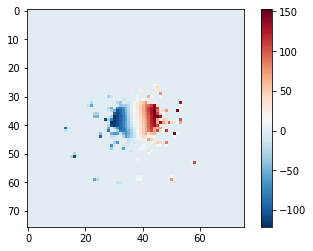

In [11]:
# This is how many galaxies you have in your map_array_ml cube


# To prepare the map cube (map_array_ml) for ML algorithms,
# it is necessary to first cut off all the empty rows.

# Removing all rows that were not filled (above)
data = map_array_ml[~np.all(map_array_ml == 0, axis=1)]
#print(np.shape(data))
plt.imshow(np.reshape(data[60], (76,76)), cmap='RdBu_r')
plt.colorbar()
plt.show()
data_length = np.shape(data)[0]
map_array_ml = data

size = int(np.sqrt(np.shape(map_array_ml[0])[0]))
map_array_ml = data
#map_array_ml = np.ma.masked_where(data==0., data)

### Now look at the distribution of each spaxel :)


In [12]:
# Maybe unflatten it first?
full_data = np.reshape(map_array_ml,(np.shape(map_array_ml)[0],shape,shape))
n_galaxies = np.shape(map_array_ml)[0]
print(np.shape(full_data))

MB_matrix = np.zeros(( np.shape(map_array_ml)[0],full_data[0,:,:].size))
for i in range(np.shape(map_array_ml)[0]):
    MB_array = full_data[i,:,:].flatten()
    MB_arrayStd = (MB_array - MB_array.mean())/MB_array.std()
    MB_matrix[i,:] = MB_arrayStd
 
# Re-flatten
print(np.shape(MB_matrix))

MB_matrix_flat = np.reshape(MB_matrix, (np.shape(MB_matrix)[0], shape,shape))

(1043, 76, 76)
(1043, 5776)


In [13]:
###But this matrix is huge

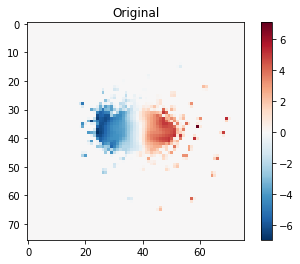

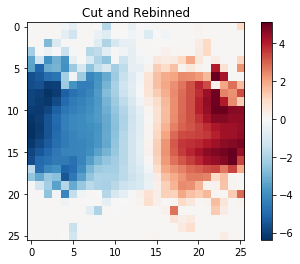

676


<Figure size 432x288 with 0 Axes>

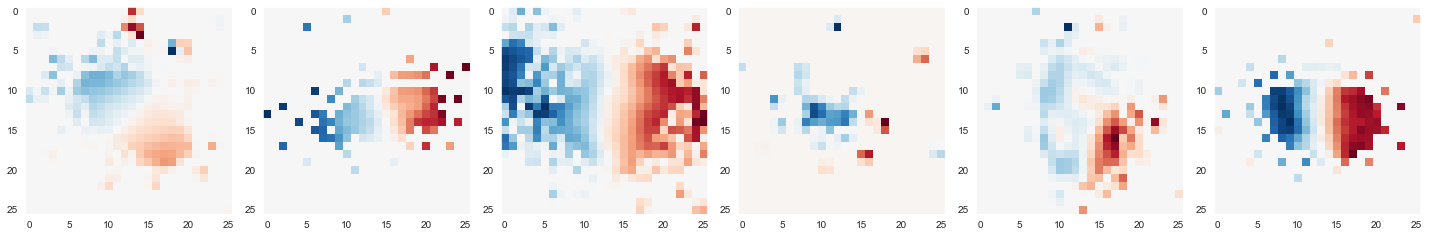

In [14]:

sidecut = 25
factor = 1

full_data_cut = MB_matrix_flat[:,sidecut:76-sidecut,sidecut:76-sidecut]

idx = 100
rebin = scipy.ndimage.zoom(full_data_cut[idx,:,:],factor, order=0)


plt.clf()
plt.imshow(MB_matrix_flat[idx,:,:], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
plt.colorbar()
plt.title('Original')
plt.show()
plt.clf()
plt.imshow(rebin, cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
plt.title('Cut and Rebinned')
plt.colorbar()
plt.show()



print(np.shape(rebin)[0]**2)

# Now resize EVERYTHING
resized_full_data = np.zeros((np.shape(full_data_cut)[0], np.shape(rebin)[0], np.shape(rebin)[1]))
for j in range(np.shape(full_data_cut)[0]):
    rebinned = scipy.ndimage.zoom(full_data_cut[j,:,:], factor, order=0)
    resized_full_data[j,:,:] = rebinned
    
    
# plot a random collection of galaxies once they have been rebinned and resized
plt.clf()
sns.set_style("dark")
fig = plt.figure(figsize = (25,15))
fig.subplots_adjust(hspace=0.3, 
                    wspace=0.15)

for j in range(6):
    ax = fig.add_subplot(1,6, j+1)
    
    ran_int = randint(0,np.shape(resized_full_data)[0] - 1)
    im = ax.imshow(resized_full_data[ran_int,:,:], cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
plt.show()

In [27]:
MB_matrix_rescaled = np.reshape(resized_full_data, 
                                (np.shape(resized_full_data)[0], np.shape(resized_full_data)[1]**2))

<Figure size 432x288 with 0 Axes>

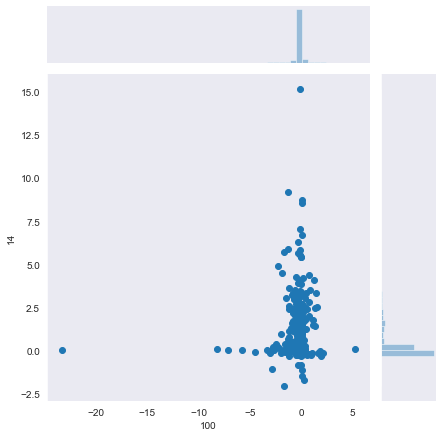

In [28]:

plt.clf()

x = MB_matrix_rescaled[:,10]
y = MB_matrix_rescaled[:,101]
g = (sns.jointplot(x, y)
        .set_axis_labels("100", "14"));#, kind="hex"

# IDK these all look really correlated



In [19]:
### Try producing a marginal dist

847


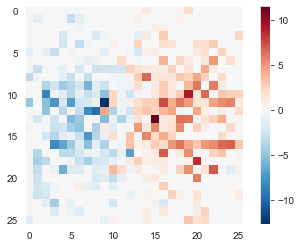

In [29]:

value = randint(0, np.shape(MB_matrix)[0])
print(value)

frankenstein_array = np.zeros(np.shape(MB_matrix_rescaled))

for i in range(np.shape(MB_matrix_rescaled)[0]):
    frankenstein_gal = []
    for j in range(np.shape(MB_matrix_rescaled)[1]):
        ran_int = randint(0,np.shape(MB_matrix_rescaled)[0] - 1)
        frankenstein_gal.append(MB_matrix_rescaled[ran_int,j])
    frankenstein_array[i,:] = frankenstein_gal
    
plt.clf()
plt.imshow(np.reshape(frankenstein_gal, (np.shape(rebin)[0],np.shape(rebin)[0])), cmap='RdBu_r', norm=MidpointNormalize(midpoint=0))
plt.colorbar()
plt.show()

<Figure size 432x288 with 0 Axes>

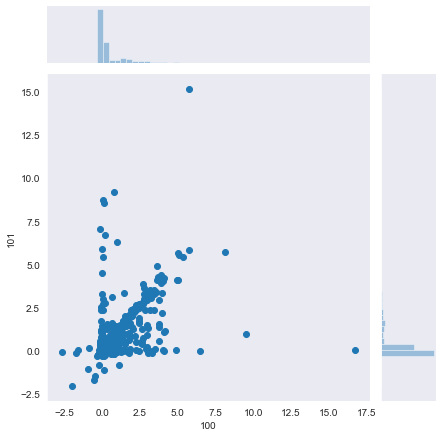

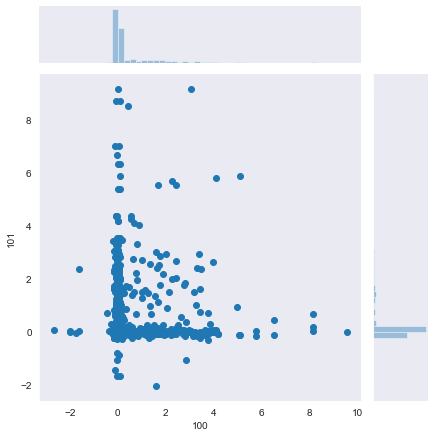

In [30]:
plt.clf()

x = MB_matrix_rescaled[:,100]
y = MB_matrix_rescaled[:,101]
g = (sns.jointplot(x, y)
        .set_axis_labels("100", "101"));#, kind="hex"

x = frankenstein_array[:,100]
y = frankenstein_array[:,101]
g = (sns.jointplot(x, y)
        .set_axis_labels("100", "101"));#, kind="hex"

In [169]:
###Frankenstein_gal is the same length and size as our actual data, let's run an RFR to see what we're dealing with

(1043, 676) (1043, 676)
finding test and train indices...
training fold 0


/Users/beckynevin/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


predicting...
0.0 0.34844963002616763
0.0 0.4642640904195754
0.0 0.0691199457028592
0.0 0.11497774701697121
0.0 0.05457449115740466
0.0 0.33081662063168005
0.0 0.13395330483741968
0.0 0.15457449115740468
0.0 0.24401971224387697
0.0 0.06952320156242575


<Figure size 432x288 with 0 Axes>

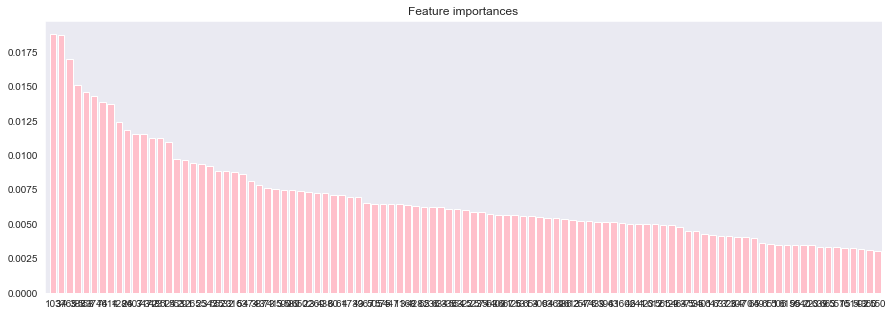

Importance in Order ~~~~
mostimp [103  37 465 388 558 374  76 414 128  24 607 347 348 231 524 553 291 265
  25 343 552 532 316  53 474 387 373 413 590 589 650  22 369 438  60  61
 473  49 367 505 575 447  11 368 428  62 536 634 336 554 322 523 574 563
 400 667 126 531 654 309  63 460 386 613 257 476 439 396  43 160  42 641
 423 612 565 129 464 375 535 401 647 637 326 307 470  64 591 651 506 615
  99 540 223 639 663 557  16 514 592 360] [0.01881362 0.01875952 0.01698203 0.01510974 0.0145932  0.01429718
 0.01388861 0.01374547 0.01237745 0.01186368 0.01156997 0.01154182
 0.01127318 0.01125917 0.01092693 0.00976059 0.00962023 0.00941202
 0.00937851 0.00921081 0.00888665 0.00883542 0.00880165 0.00865325
 0.00814003 0.00783404 0.00759381 0.00751249 0.00749615 0.00747331
 0.00738832 0.00734275 0.00728097 0.00724933 0.00708489 0.00707506
 0.00697767 0.00694828 0.00652288 0.00646463 0.00643578 0.00642304
 0.00642072 0.00640333 0.0063384  0.00625294 0.00622019 0.00621623
 0.00608964 0.00605734 0

In [31]:
most_imp, value = run_RFR(np.ma.masked_where(MB_matrix_rescaled==0, MB_matrix_rescaled), 
                   np.ma.masked_where(frankenstein_array==0, frankenstein_array), 100)

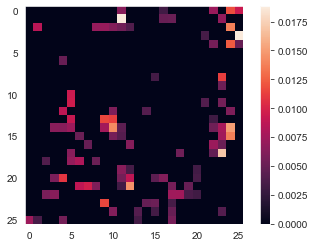

In [32]:
#Wait so you need to figure out which spaxel this is
#322, where is this?

full_length = np.shape(MB_matrix_rescaled)[1]
empty = np.zeros(np.shape(MB_matrix_rescaled)[1])
for j in range(len(most_imp)):
    empty[most_imp[j]] = value[j]
side = int(np.sqrt(len(empty)))
twod = np.reshape(empty, (side,side))
plt.imshow(twod)
plt.colorbar()
plt.show()


In [23]:
import numpy as np
import pandas as pd

#!/usr/bin/env python


#Usage: a simple implementation of an RFR on toy data



import matplotlib
#matplotlib.use('Agg')
import numpy as np
#from astropy.stats import biweight_scale
from scipy.stats import kurtosis
import matplotlib.pyplot as plt
import time
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from astropy.io import fits


########################### ADJUSTABLE PARAMETERS ###########################
Nfolds = 10
Ndat = 5000

#############################################################################
 



    
def testAndTrainIndices(test_fold, Nfolds, folds):
    
    print('finding test and train indices...')

    train_folds = np.delete(np.arange(Nfolds), test_fold)

    test_ind   = [i for i in range(len(folds)) if folds[i]==test_fold]
    train_ind  = [i for i in range(len(folds)) if folds[i] in train_folds]

    return test_ind, train_ind



def run_RFR(features_real,features_fake, nimp):
    print(np.shape(features_real), np.shape(features_fake))
    # np.vstack((a,b))
    features = np.vstack((features_real,features_fake))
    
    Nfeatures = len(features[0])
    
    #dat['features']#.reshape(-1,1)
    label_real = np.zeros(np.shape(features_real)[0])
    
    label_fake = np.ones(np.shape(features_fake)[0])
    
    
    
    labels = np.hstack((label_real,label_fake))
    
    
    folds = np.arange(len(labels))%Nfolds
    
    
    #Test on fold 0, train on the remaining folds:
    test_ind, train_ind = testAndTrainIndices(test_fold = 0, Nfolds = Nfolds, folds=folds)
    
    #divide features and labels into test and train sets:
    test_features = features[test_ind]
    test_labels   = labels[test_ind]
   
    train_features  = features[train_ind]
    train_labels    = labels[train_ind]

    print('training fold 0')
    #make a random forest model:
    model = RandomForestRegressor(max_depth=10, random_state=42)
    model.fit(train_features, train_labels)

    print('predicting...')
    # Predict on new data
    preds = model.predict(test_features)
    #print out the first few mass predictions to see if they make sense:
    for h in range(10):
        print(test_labels[h], preds[h])


    
    x = np.linspace(min([np.min(test_labels), np.min(preds)]), \
                        max([np.max(test_labels), np.max(preds)]), 100)
    '''plt.plot(x, x, c='k', ls='--')
    plt.scatter(test_labels, preds, s=3, alpha=0.3)
    plt.xlabel('truth')
    plt.ylabel('prediction')
    plt.show()'''
    #plt.savefig('rfrscatter.pdf')
    plt.clf()

    # rank feature importance:
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Plot the feature importances of the forest
    plt.figure(figsize=(15,5))
    plt.title("Feature importances")
    plt.bar(range(Nfeatures), importances[indices],  align="center", color='pink')#yerr=std[indices],
    plt.xticks(range(Nfeatures), indices)
    plt.xlim([-1, nimp+0.5])
    plt.show()
    
    #plt.savefig('feature_importance_'+str(run)+'_rando.pdf')
    
    
    
    print('Importance in Order ~~~~')
    print('mostimp', indices[0:nimp], importances[indices][0:nimp], std[indices][0:nimp])
    
  
    return indices[0:nimp], importances[indices][0:nimp]


/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/beckynevin/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
